# Training
This notebook trains the model with 3 fold cross validation.

In [1]:
from codecarbon import EmissionsTracker
import logging
output_directory = "/fp/homes01/u01/ec-krimhau/thesis_code/"

tracker = EmissionsTracker(output_dir=output_directory)
tracker.start()

[codecarbon INFO @ 07:52:43] [setup] RAM Tracking...
[codecarbon INFO @ 07:52:43] [setup] GPU Tracking...
[codecarbon INFO @ 07:52:43] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 07:52:43] [setup] CPU Tracking...
[codecarbon WARNING @ 07:52:43] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 07:52:46] We saw that you have a AMD EPYC 7642 48-Core Processor but we don't know it. Please contact us.
[codecarbon INFO @ 07:52:46] CPU Model on constant consumption mode: AMD EPYC 7642 48-Core Processor
[codecarbon INFO @ 07:52:46] >>> Tracker's metadata:
[codecarbon INFO @ 07:52:46]   Platform system: Linux-5.14.0-362.8.1.el9_3.x86_64-x86_64-with-glibc2.34
[codecarbon INFO @ 07:52:46]   Python version: 3.11.3
[codecarbon INFO @ 07:52:46]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 07:52:46]   Available RAM : 256.000 GB
[codecarbon INFO @ 07:52:46]   CPU count: 24
[codecarbon INFO @ 07:52:46]   CPU model: AMD EPYC 7642 48-Core Processor
[codecarbon 

In [2]:
logging.getLogger('codecarbon').setLevel(logging.WARNING)

# Imports and setup

In [3]:
import sys
# Need this to load the packages correct in Fox ml nodes.
sys.path.append("/fp/homes01/u01/ec-krimhau/.local/lib/python3.11/site-packages")

In [4]:
import os
import gc
import copy
import time
import random
import string
import joblib

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

# Utils
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, KFold

# For Transformer Models
from transformers import AutoTokenizer, AutoModel, AutoConfig, AdamW
from transformers import DataCollatorWithPadding
import datasets
# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
y_ = Fore.YELLOW
sr_ = Style.RESET_ALL

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import wandb

In [5]:
# Load .env file
%load_ext dotenv
%dotenv /fp/homes01/u01/ec-krimhau/thesis_code/.env

In [6]:
# Get wandb api key from .env file
wandb_api_key = os.getenv('WANDB_API_KEY')
# Login to wandb to track results
wandb.login(key = wandb_api_key) # API key

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: haugerud-kristian (krimhau). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /fp/homes01/u01/ec-krimhau/.netrc


True

In [7]:
# Function to generate a unique random identifier for experiment tracking.
def id_generator(size=12, chars=string.ascii_lowercase + string.digits):
    return ''.join(random.SystemRandom().choice(chars) for _ in range(size))


HASH_NAME = id_generator(size=12)
print(HASH_NAME)

cdzut7azn4hr


In [8]:
# Config for the model
CONFIG = {"seed": 42,
          "epochs": 3,
          "model_name": "microsoft/deberta-v3-base",
          "train_batch_size": 8,
          "valid_batch_size": 16,
          "max_length": 512,
          "learning_rate": 1e-5,
          "scheduler": 'CosineAnnealingLR',
          "min_lr": 1e-6,
          "T_max": 500,
          "weight_decay": 1e-6,
          "n_fold": 3,
          "n_accumulate": 1,
          "num_classes": 2,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
          "hash_name": HASH_NAME,
          "_wandb_kernel": "deb",
          }

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])
CONFIG['group'] = f'{HASH_NAME}-Baseline'


In [9]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [10]:
# Splits the data into train and test. Validation is done using KFold.
def train_test_split(df, train_percent=.85, seed=42):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    train = df.iloc[perm[:train_end]]
    test = df.iloc[perm[train_end:]]
    return train, test

In [11]:
import pandas as pd
path_to_files = "//fp/projects01/ec307/ec-krimhau/jira_datasets"
file_name = "highest_vs_rest_min_len_25th_balanced_jira.csv"
!ls /fp/projects01/ec307/ec-krimhau/jira_datasets

highest_high_vs_low_lowest_balanced_jira.csv	high_highest_vs_rest
highest_vs_lowest_balanced_jira.csv		high_vs_rest
highest_vs_rest_min_len_25th_balanced_jira.csv	jira_clean_with_all_cols.csv


In [12]:
priority_df = pd.read_csv(f"{path_to_files}/{file_name}")
priority_df

,label,text
0,1,codejava in importtestmodule mod selffspathpyi...
1,0,o the goal is move the add node delete node ad...
2,0,fileformatwriterwrite will sort the partition ...
3,1,it would be nice to have the ability in mapred...
4,1,enable maker checker in go to systemconfigure ...
...,...,...
89551,1,for jbide please perform the following make su...
89552,0,the main idea to add a few strategies of index...
89553,0,each partition has its own version number so t...
89554,1,expected behavior jibmaven task published the ...


In [13]:
# Check if NaN
priority_df.isna().any()

label    False
text     False
dtype: bool

In [14]:
priority_df

,label,text
0,1,codejava in importtestmodule mod selffspathpyi...
1,0,o the goal is move the add node delete node ad...
2,0,fileformatwriterwrite will sort the partition ...
3,1,it would be nice to have the ability in mapred...
4,1,enable maker checker in go to systemconfigure ...
...,...,...
89551,1,for jbide please perform the following make su...
89552,0,the main idea to add a few strategies of index...
89553,0,each partition has its own version number so t...
89554,1,expected behavior jibmaven task published the ...


In [15]:
priority_df["label"].value_counts()

label
1    44778
0    44778
Name: count, dtype: int64

In [16]:
train_hp_df , test_hp_df = train_test_split(priority_df)

In [17]:
df = train_hp_df
df

,label,text
19418,0,the querynifi reporting task does not keep tra...
52661,0,if there is a problem with the validity of the...
52529,1,this bug was imported from another system and ...
40999,0,without the explicit setting of the property h...
28166,1,this usually causes multiple test failures esp...
...,...,...
59263,0,i needed functionality for the return numbers ...
68623,0,assume you are using the following configurati...
16484,0,reproduce： create three tables hive e explain ...
27086,1,start a server with phoenixallowsystemcatalogr...


In [18]:
df.reset_index(inplace = True)
df = df.drop('index', axis=1)
df

,label,text
0,0,the querynifi reporting task does not keep tra...
1,0,if there is a problem with the validity of the...
2,1,this bug was imported from another system and ...
3,0,without the explicit setting of the property h...
4,1,this usually causes multiple test failures esp...
...,...,...
76117,0,i needed functionality for the return numbers ...
76118,0,assume you are using the following configurati...
76119,0,reproduce： create three tables hive e explain ...
76120,1,start a server with phoenixallowsystemcatalogr...


In [19]:
gkf = GroupKFold(n_splits=CONFIG['n_fold'])

for fold, ( _, val_) in enumerate(gkf.split(X=df, groups=df.text)):
    df.loc[val_ , "kfold"] = int(fold)
    
df["kfold"] = df["kfold"].astype(int)


In [20]:
df.groupby('kfold')['label'].value_counts()


kfold  label
0      1        12846
       0        12528
1      0        12804
       1        12570
2      0        12796
       1        12578
Name: count, dtype: int64

In [21]:
df

,label,text,kfold
0,0,the querynifi reporting task does not keep tra...,0
1,0,if there is a problem with the validity of the...,0
2,1,this bug was imported from another system and ...,0
3,0,without the explicit setting of the property h...,2
4,1,this usually causes multiple test failures esp...,0
...,...,...,...
76117,0,i needed functionality for the return numbers ...,1
76118,0,assume you are using the following configurati...,1
76119,0,reproduce： create three tables hive e explain ...,2
76120,1,start a server with phoenixallowsystemcatalogr...,0


In [22]:
class HP_Dataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        self.targets = df['label'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        return {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            'target': self.targets[index]
        }

In [23]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])


In [24]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

In [25]:
class HP_Model(nn.Module):
    def __init__(self, model_name):
        super(HP_Model, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.config = AutoConfig.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.pooler = MeanPooling()
        self.fc = nn.Linear(self.config.hidden_size, CONFIG['num_classes'])
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.pooler(out.last_hidden_state, mask)
        out = self.drop(out)
        outputs = self.fc(out)
        return outputs

In [26]:
def criterion(outputs, labels):
    return nn.CrossEntropyLoss()(outputs, labels)

In [27]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        loss = loss / CONFIG['n_accumulate']
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score



In [29]:
def all_classification_report(y_true, y_pred, target_names = ['Non_HP', 'HP'], digits=4):
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names = target_names, digits=4))
    
    accuracy =round(accuracy_score(y_true, y_pred),4)
    print("Accuracy =",  accuracy)
    f1score = round(f1_score(y_true, y_pred),4)
    print("F1_score =", f1score)

    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Non_HP', 'HP'])
    ax.yaxis.set_ticklabels(['Non_HP', 'HP'])
    
    return  accuracy , f1score
    
    

In [30]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    dataset_size = 0
    running_loss = 0.0
    
    y_pred = []
    y_true = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        

        predictions = torch.argmax(outputs, dim=-1).flatten().tolist()
        
        target = targets.tolist()

        y_pred.extend(predictions)
        y_true.extend(target)
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,LR=optimizer.param_groups[0]['lr'])   
    
    
    accuracy, f1score = all_classification_report(y_true,y_pred)
    gc.collect()
    
    return epoch_loss , accuracy , f1score

In [31]:
def run_training(model, optimizer, scheduler, device, num_epochs, fold):
    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_loss = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss, accuracy , f1score = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
      
        history['Valid accuracy'].append(accuracy)
        history['Valid f1score'].append(f1score)



        
        # Log the metrics
        wandb.log({"Train Loss": train_epoch_loss})
        wandb.log({"Valid Loss": val_epoch_loss})
        wandb.log({"Valid Accuracy": accuracy})
        wandb.log({"Valid F1_score": f1score})


        
        # deep copy the model
        if val_epoch_loss <= best_epoch_loss:
            print(f"{b_}Validation Loss Improved ({best_epoch_loss} ---> {val_epoch_loss})")
            best_epoch_loss = val_epoch_loss
            run.summary["Best Loss"] = best_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"{HASH_NAME}-Loss-Fold-{fold}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: {:.4f}".format(best_epoch_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history


In [32]:
def prepare_loaders(fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = HP_Dataset(df_train, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])
    valid_dataset = HP_Dataset(df_valid, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], collate_fn=collate_fn, 
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], collate_fn=collate_fn,
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

In [33]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

====== Fold: 0 ======


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|██████████| 1586/1586 [03:40<00:00,  7.21it/s, Epoch=1, LR=3.02e-6, Valid_Loss=0.593]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7262    0.6046    0.6599     12528
          HP     0.6685    0.7777    0.7190     12846

    accuracy                         0.6922     25374
   macro avg     0.6974    0.6912    0.6894     25374
weighted avg     0.6970    0.6922    0.6898     25374

Accuracy = 0.6922
F1_score = 0.719
Validation Loss Improved (inf ---> 0.5925130673387686)
Model Saved



100%|██████████| 1586/1586 [03:40<00:00,  7.19it/s, Epoch=2, LR=3.74e-6, Valid_Loss=0.572]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7476    0.6133    0.6739     12528
          HP     0.6791    0.7981    0.7338     12846

    accuracy                         0.7069     25374
   macro avg     0.7134    0.7057    0.7038     25374
weighted avg     0.7129    0.7069    0.7042     25374

Accuracy = 0.7069
F1_score = 0.7338
Validation Loss Improved (0.5925130673387686 ---> 0.5721527413808116)
Model Saved



100%|██████████| 1586/1586 [03:40<00:00,  7.20it/s, Epoch=3, LR=9.93e-6, Valid_Loss=0.576]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7457    0.6206    0.6774     12528
          HP     0.6820    0.7936    0.7336     12846

    accuracy                         0.7082     25374
   macro avg     0.7138    0.7071    0.7055     25374
weighted avg     0.7134    0.7082    0.7058     25374

Accuracy = 0.7082
F1_score = 0.7336

Training complete in 1h 28m 21s
Best Loss: 0.5722


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Train Loss,█▄▁
Valid Accuracy,▁▇█
Valid F1_score,▁██
Valid Loss,█▁▂
Best Loss,0.57215
Train Loss,0.51672
Valid Accuracy,0.7082
Valid F1_score,0.7336
Valid Loss,0.5762



====== Fold: 1 ======


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|██████████| 1586/1586 [03:50<00:00,  6.89it/s, Epoch=1, LR=3.02e-6, Valid_Loss=0.564]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6975    0.7222    0.7096     12804
          HP     0.7064    0.6809    0.6934     12570

    accuracy                         0.7017     25374
   macro avg     0.7019    0.7016    0.7015     25374
weighted avg     0.7019    0.7017    0.7016     25374

Accuracy = 0.7017
F1_score = 0.6934
Validation Loss Improved (inf ---> 0.5643327627972601)
Model Saved



100%|██████████| 1586/1586 [03:50<00:00,  6.89it/s, Epoch=2, LR=3.74e-6, Valid_Loss=0.573]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6859    0.7759    0.7281     12804
          HP     0.7365    0.6380    0.6837     12570

    accuracy                         0.7076     25374
   macro avg     0.7112    0.7070    0.7059     25374
weighted avg     0.7110    0.7076    0.7061     25374

Accuracy = 0.7076
F1_score = 0.6837



100%|██████████| 1586/1586 [03:50<00:00,  6.88it/s, Epoch=3, LR=9.93e-6, Valid_Loss=0.566]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6866    0.7760    0.7286     12804
          HP     0.7369    0.6391    0.6846     12570

    accuracy                         0.7082     25374
   macro avg     0.7117    0.7076    0.7066     25374
weighted avg     0.7115    0.7082    0.7068     25374

Accuracy = 0.7082
F1_score = 0.6846

Training complete in 1h 27m 50s
Best Loss: 0.5643


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Train Loss,█▄▁
Valid Accuracy,▁▇█
Valid F1_score,█▁▂
Valid Loss,▁█▂
Best Loss,0.56433
Train Loss,0.51857
Valid Accuracy,0.7082
Valid F1_score,0.6846
Valid Loss,0.5659



====== Fold: 2 ======


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|██████████| 1586/1586 [03:45<00:00,  7.02it/s, Epoch=1, LR=3.02e-6, Valid_Loss=0.599]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7756    0.4863    0.5978     12796
          HP     0.6212    0.8569    0.7202     12578

    accuracy                         0.6700     25374
   macro avg     0.6984    0.6716    0.6590     25374
weighted avg     0.6991    0.6700    0.6585     25374

Accuracy = 0.67
F1_score = 0.7202
Validation Loss Improved (inf ---> 0.5994550750461737)
Model Saved



100%|██████████| 1586/1586 [03:45<00:00,  7.03it/s, Epoch=2, LR=3.74e-6, Valid_Loss=0.567]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7494    0.6089    0.6719     12796
          HP     0.6659    0.7929    0.7239     12578

    accuracy                         0.7001     25374
   macro avg     0.7077    0.7009    0.6979     25374
weighted avg     0.7080    0.7001    0.6977     25374

Accuracy = 0.7001
F1_score = 0.7239
Validation Loss Improved (0.5994550750461737 ---> 0.5671450754490607)
Model Saved



100%|██████████| 1586/1586 [03:45<00:00,  7.03it/s, Epoch=3, LR=9.93e-6, Valid_Loss=0.593]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7461    0.5903    0.6591     12796
          HP     0.6562    0.7957    0.7192     12578

    accuracy                         0.6921     25374
   macro avg     0.7012    0.6930    0.6892     25374
weighted avg     0.7016    0.6921    0.6889     25374

Accuracy = 0.6921
F1_score = 0.7192

Training complete in 1h 27m 44s
Best Loss: 0.5671


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Train Loss,█▄▁
Valid Accuracy,▁█▆
Valid F1_score,▂█▁
Valid Loss,█▁▆
Best Loss,0.56715
Train Loss,0.5059
Valid Accuracy,0.6921
Valid F1_score,0.7192
Valid Loss,0.59252


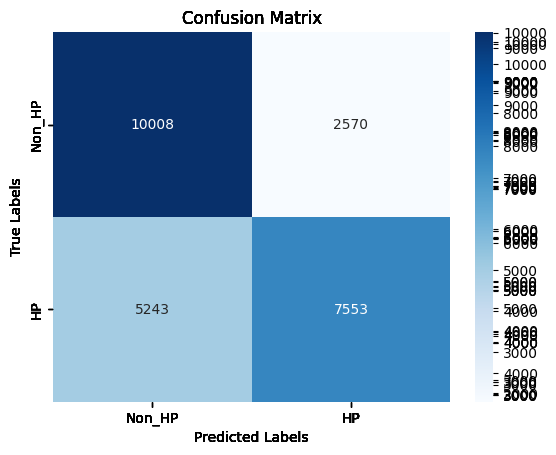

In [34]:
for fold in range(0, CONFIG['n_fold']):
    print(f"{y_}====== Fold: {fold} ======{sr_}")
    run = wandb.init(project='jira_high_vs_rest_min_len_25th_percentile', 
                     config=CONFIG,
                     job_type='Train',
                     group=CONFIG['group'],
                     tags=[CONFIG['model_name'], f'{HASH_NAME}'],
                     name=f'{HASH_NAME}-fold-{fold}',
                     anonymous='must')
    
    # Create Dataloaders
    train_loader, valid_loader = prepare_loaders(fold=fold)
    
    model = HP_Model(CONFIG['model_name'])
    model.to(CONFIG['device'])
    
    # Define Optimizer and Scheduler
    optimizer = AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
    scheduler = fetch_scheduler(optimizer)
    
    model, history = run_training(model, optimizer, scheduler,
                                  device=CONFIG['device'],
                                  num_epochs=CONFIG['epochs'],
                                  fold=fold)
    
    run.finish()
    
    del model, history, train_loader, valid_loader
    _ = gc.collect()
    print()

<h2> Testing Inference </h2>


In [35]:
import warnings,transformers,logging,torch

warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

In [36]:
test_df = test_hp_df

In [37]:
test_df

,label,text
54583,0,after patching hbase where lzo compression is ...
59967,0,converter library to convert industry foundati...
26485,1,for jbide please perform the following tasks c...
34297,0,ats application timeline severservice we alrea...
1286,1,the current code in applicationmasterservice i...
...,...,...
6265,1,on which uses a db conversion a preexisitng ac...
54886,1,weve talked about putting setters on mojos for...
76820,1,hi guysi found this issue when trying to creat...
860,0,given a bean field declared with an multifield...


In [38]:
class HP_TestDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        samples = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            
        }

        if 'token_type_ids' in inputs:
            samples['token_type_ids'] = inputs['token_type_ids']
        
        return samples

In [39]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])

softmax = nn.Softmax(dim=1)
model = HP_Model(CONFIG['model_name'])

In [40]:
def prepare_test_loader(test_df):    
    test_dataset = HP_TestDataset(test_df, 
                                   tokenizer=CONFIG['tokenizer'], 
                                   max_length=CONFIG['max_length'])
    
    test_loader = DataLoader(test_dataset, 
                             batch_size=CONFIG['valid_batch_size'], 
                             collate_fn=collate_fn, 
                             num_workers=2, 
                             shuffle=False, 
                             pin_memory=True, 
                             drop_last=False)
    return test_loader

test_loader = prepare_test_loader(test_df)

In [41]:
@torch.no_grad()
def inference(test_loader, model, device):
    preds = []
    preds_target = []
    model.eval()
    model.to(device)
    
    bar = tqdm(enumerate(test_loader), total=len(test_loader))
    
    for step, data in bar: 
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        
        output = model(ids, mask)
        y_preds = softmax(torch.tensor(output.to('cpu'))).numpy()
        pred_target = torch.argmax(output, dim=-1).flatten().tolist()
        
        preds.append(y_preds)
        preds_target.append(pred_target) 
    predictions = np.concatenate(preds)
    predictions_label = np.concatenate(preds_target)
    return predictions , predictions_label

In [42]:
deberta_predictions = []
deberta_predictions_labels = []



for fold in range(0, CONFIG['n_fold']):
    print("Fold {}".format(fold))
    
    state = torch.load(f'{HASH_NAME}-Loss-Fold-{fold}.bin')
    model.load_state_dict(state)
    
    prediction, predictions_label = inference(test_loader, model, CONFIG['device'])
    deberta_predictions.append(prediction)
    deberta_predictions_labels.append(predictions_label)
    del state, prediction; gc.collect()
    torch.cuda.empty_cache()
del model

Fold 0


100%|██████████| 840/840 [01:53<00:00,  7.38it/s]


Fold 1


100%|██████████| 840/840 [01:53<00:00,  7.37it/s]


Fold 2


100%|██████████| 840/840 [01:53<00:00,  7.37it/s]


In [43]:
deberta_predictions


[array([[2.5552234e-01, 7.4447769e-01],
        [9.4422060e-01, 5.5779349e-02],
        [4.5716055e-04, 9.9954283e-01],
        ...,
        [6.2843752e-01, 3.7156245e-01],
        [5.0506634e-01, 4.9493366e-01],
        [7.5984627e-01, 2.4015373e-01]], dtype=float32),
 array([[0.30010578, 0.69989413],
        [0.9530199 , 0.04698011],
        [0.0095847 , 0.99041533],
        ...,
        [0.6967184 , 0.30328155],
        [0.50805485, 0.49194515],
        [0.86450255, 0.1354974 ]], dtype=float32),
 array([[0.18194963, 0.81805044],
        [0.9210891 , 0.07891092],
        [0.00266797, 0.9973321 ],
        ...,
        [0.50376976, 0.4962302 ],
        [0.6103056 , 0.38969436],
        [0.87513536, 0.1248647 ]], dtype=float32)]

In [44]:
predictions = np.mean(deberta_predictions, axis=0)
predictions

array([[0.24585925, 0.7541408 ],
       [0.9394432 , 0.06055679],
       [0.00423661, 0.9957635 ],
       ...,
       [0.6096419 , 0.3903581 ],
       [0.5411422 , 0.45885774],
       [0.8331614 , 0.1668386 ]], dtype=float32)

In [45]:
len(predictions)

13434

In [46]:
predictions

array([[0.24585925, 0.7541408 ],
       [0.9394432 , 0.06055679],
       [0.00423661, 0.9957635 ],
       ...,
       [0.6096419 , 0.3903581 ],
       [0.5411422 , 0.45885774],
       [0.8331614 , 0.1668386 ]], dtype=float32)

In [47]:
test_df["prediction_0"] = predictions[:, 0] 

In [48]:
test_df["prediction_1"] = predictions[:, 1] 

In [49]:
for i in range(0, CONFIG['n_fold']):

    test_df[f"prediction_label_fold_{i}"] = deberta_predictions_labels[i]


In [50]:
test_df

,label,text,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2
54583,0,after patching hbase where lzo compression is ...,0.245859,0.754141,1,1,1
59967,0,converter library to convert industry foundati...,0.939443,0.060557,0,0,0
26485,1,for jbide please perform the following tasks c...,0.004237,0.995763,1,1,1
34297,0,ats application timeline severservice we alrea...,0.589539,0.410461,0,0,0
1286,1,the current code in applicationmasterservice i...,0.475095,0.524905,1,0,1
...,...,...,...,...,...,...,...
6265,1,on which uses a db conversion a preexisitng ac...,0.200443,0.799557,1,1,1
54886,1,weve talked about putting setters on mojos for...,0.557497,0.442503,0,0,0
76820,1,hi guysi found this issue when trying to creat...,0.609642,0.390358,0,0,0
860,0,given a bean field declared with an multifield...,0.541142,0.458858,0,0,0


In [51]:
len(test_df)

13434

In [52]:
test_df['Max'] = test_df[['prediction_0','prediction_1']].idxmax(axis=1)

In [53]:
test_df["pred"] = test_df['Max'].apply(lambda x: x.replace("prediction_0", "0"))

In [54]:
test_df["pred"] = test_df['pred'].apply(lambda x: x.replace("prediction_1", "1"))


In [55]:
test_df["pred"] = test_df["pred"].astype(int)

In [56]:
test_df

,label,text,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2,Max,pred
54583,0,after patching hbase where lzo compression is ...,0.245859,0.754141,1,1,1,prediction_1,1
59967,0,converter library to convert industry foundati...,0.939443,0.060557,0,0,0,prediction_0,0
26485,1,for jbide please perform the following tasks c...,0.004237,0.995763,1,1,1,prediction_1,1
34297,0,ats application timeline severservice we alrea...,0.589539,0.410461,0,0,0,prediction_0,0
1286,1,the current code in applicationmasterservice i...,0.475095,0.524905,1,0,1,prediction_1,1
...,...,...,...,...,...,...,...,...,...
6265,1,on which uses a db conversion a preexisitng ac...,0.200443,0.799557,1,1,1,prediction_1,1
54886,1,weve talked about putting setters on mojos for...,0.557497,0.442503,0,0,0,prediction_0,0
76820,1,hi guysi found this issue when trying to creat...,0.609642,0.390358,0,0,0,prediction_0,0
860,0,given a bean field declared with an multifield...,0.541142,0.458858,0,0,0,prediction_0,0


In [57]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(test_df["label"].values, test_df["pred"].values)

print(cf_matrix)

[[4279 2371]
 [1590 5194]]


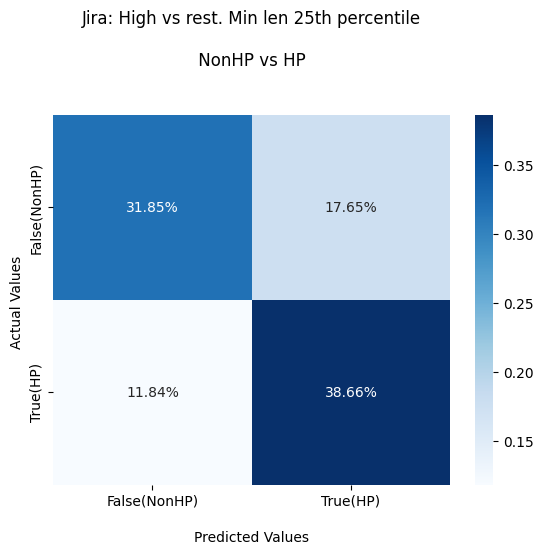

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Jira: High vs rest. Min len 25th percentile\n\n NonHP vs HP \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False(NonHP)','True(HP)'])
ax.yaxis.set_ticklabels(['False(NonHP)','True(HP)'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [59]:
from sklearn.metrics import classification_report


print(classification_report(test_df["label"].values, test_df["pred"].values))

              precision    recall  f1-score   support

           0       0.73      0.64      0.68      6650
           1       0.69      0.77      0.72      6784

    accuracy                           0.71     13434
   macro avg       0.71      0.70      0.70     13434
weighted avg       0.71      0.71      0.70     13434



In [60]:
tracker.stop()

0.04288447706183805